In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import RobustScaler
from predict import extract_features


In [2]:
# training parameters
epochs = 30
batch_size = 16
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99)
# opt = tf.keras.optimizers.Adam()
input_path = '../../data/simulated_2d/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/train/target_data.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/train/sizes.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/val/target_data.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/val/sizes.pkl', 'rb'))


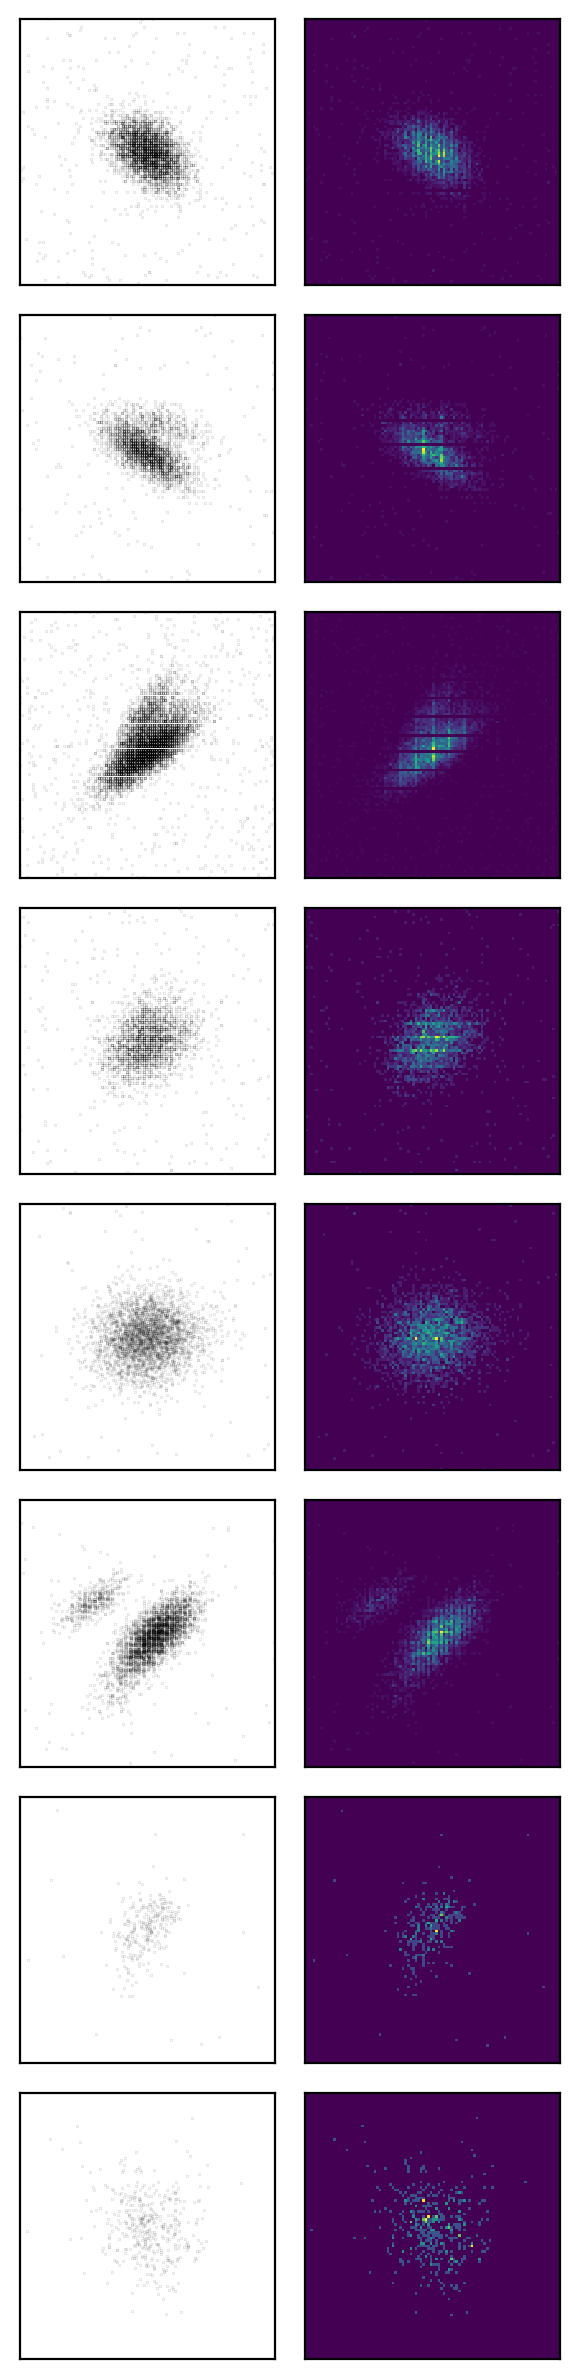

In [4]:
nr = 8
c = 0
plt.figure(figsize=(3, 12), dpi=200)
for i in range(0, nr*2, 2):
    idx = np.random.choice(len(x_train))
    plt.subplot(nr, 2, i+1)
    plt.scatter(x_train[idx][:,0], x_train[idx][:,1], s=0.01, c='k', alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.subplot(nr, 2, i+2)
    plt.pcolormesh(extract_features(x_train[idx]).T)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


In [5]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train).squeeze()
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val).squeeze()


In [6]:
# optionally add reference fraction prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [7]:
# standardize outputs
scalery = RobustScaler()

y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [8]:
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]


In [9]:
x_train.shape

(13000, 100, 100, 1)

In [10]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv2D(32, kernel_size=10, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=10, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=10, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          409664

In [11]:
# plot model

# !pip install pydot
# !pip install graphviz

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
# )


In [12]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/30


I0000 00:00:1726646612.664232   22360 service.cc:145] XLA service 0x7f73ac98be90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726646612.664277   22360 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1726646612.697558   22360 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.38945, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 19s - loss: 0.4588 - val_loss: 0.3895 - 19s/epoch - 24ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.38945 to 0.35757, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3843 - val_loss: 0.3576 - 4s/epoch - 5ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.35757 to 0.34681, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3676 - val_loss: 0.3468 - 4s/epoch - 5ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.34681 to 0.32973, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3491 - val_loss: 0.3297 - 4s/epoch - 5ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.32973 to 0.31967, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3367 - val_loss: 0.3197 - 4s/epoch - 5ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.31967
813/813 - 3s - loss: 0.3278 - val_loss: 0.3276 - 3s/epoch - 4ms/step
Epoch 7/30

Epoch 7: val_loss improved from 0.31967 to 0.30345, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3192 - val_loss: 0.3035 - 4s/epoch - 4ms/step
Epoch 8/30

Epoch 8: val_loss improved from 0.30345 to 0.29987, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3108 - val_loss: 0.2999 - 4s/epoch - 4ms/step
Epoch 9/30

Epoch 9: val_loss improved from 0.29987 to 0.29057, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.3040 - val_loss: 0.2906 - 4s/epoch - 4ms/step
Epoch 10/30

Epoch 10: val_loss did not improve from 0.29057
813/813 - 3s - loss: 0.3017 - val_loss: 0.2916 - 3s/epoch - 4ms/step
Epoch 11/30

Epoch 11: val_loss improved from 0.29057 to 0.28055, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2961 - val_loss: 0.2806 - 4s/epoch - 4ms/step
Epoch 12/30

Epoch 12: val_loss improved from 0.28055 to 0.27487, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2892 - val_loss: 0.2749 - 4s/epoch - 5ms/step
Epoch 13/30

Epoch 13: val_loss did not improve from 0.27487
813/813 - 3s - loss: 0.2870 - val_loss: 0.2757 - 3s/epoch - 4ms/step
Epoch 14/30

Epoch 14: val_loss did not improve from 0.27487
813/813 - 3s - loss: 0.2822 - val_loss: 0.2755 - 3s/epoch - 4ms/step
Epoch 15/30

Epoch 15: val_loss improved from 0.27487 to 0.26998, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2818 - val_loss: 0.2700 - 4s/epoch - 4ms/step
Epoch 16/30

Epoch 16: val_loss did not improve from 0.26998
813/813 - 3s - loss: 0.2750 - val_loss: 0.2718 - 3s/epoch - 4ms/step
Epoch 17/30

Epoch 17: val_loss improved from 0.26998 to 0.26952, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2752 - val_loss: 0.2695 - 4s/epoch - 4ms/step
Epoch 18/30

Epoch 18: val_loss improved from 0.26952 to 0.26848, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2672 - val_loss: 0.2685 - 4s/epoch - 5ms/step
Epoch 19/30

Epoch 19: val_loss improved from 0.26848 to 0.26731, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2673 - val_loss: 0.2673 - 4s/epoch - 4ms/step
Epoch 20/30

Epoch 20: val_loss did not improve from 0.26731
813/813 - 3s - loss: 0.2629 - val_loss: 0.2679 - 3s/epoch - 4ms/step
Epoch 21/30

Epoch 21: val_loss did not improve from 0.26731
813/813 - 3s - loss: 0.2593 - val_loss: 0.2678 - 3s/epoch - 4ms/step
Epoch 22/30

Epoch 22: val_loss did not improve from 0.26731
813/813 - 3s - loss: 0.2565 - val_loss: 0.2703 - 3s/epoch - 4ms/step
Epoch 23/30

Epoch 23: val_loss improved from 0.26731 to 0.26391, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2543 - val_loss: 0.2639 - 4s/epoch - 4ms/step
Epoch 24/30

Epoch 24: val_loss did not improve from 0.26391
813/813 - 3s - loss: 0.2505 - val_loss: 0.2651 - 3s/epoch - 4ms/step
Epoch 25/30

Epoch 25: val_loss did not improve from 0.26391
813/813 - 3s - loss: 0.2505 - val_loss: 0.2663 - 3s/epoch - 4ms/step
Epoch 26/30

Epoch 26: val_loss did not improve from 0.26391
813/813 - 3s - loss: 0.2465 - val_loss: 0.2651 - 3s/epoch - 4ms/step
Epoch 27/30

Epoch 27: val_loss did not improve from 0.26391
813/813 - 3s - loss: 0.2455 - val_loss: 0.2693 - 3s/epoch - 4ms/step
Epoch 28/30

Epoch 28: val_loss improved from 0.26391 to 0.26364, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2409 - val_loss: 0.2636 - 4s/epoch - 4ms/step
Epoch 29/30

Epoch 29: val_loss did not improve from 0.26364
813/813 - 3s - loss: 0.2387 - val_loss: 0.2653 - 3s/epoch - 4ms/step
Epoch 30/30

Epoch 30: val_loss improved from 0.26364 to 0.26338, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 - 4s - loss: 0.2364 - val_loss: 0.2634 - 4s/epoch - 5ms/step


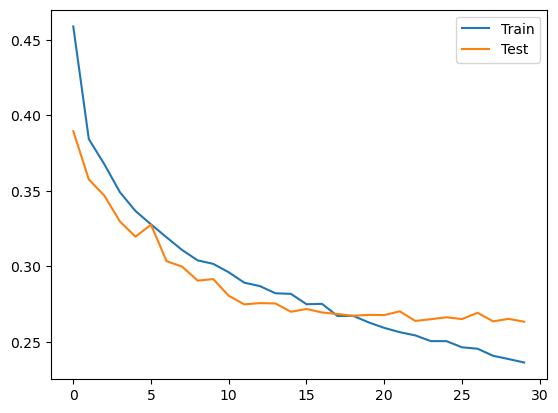

In [13]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend();


In [14]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
